In [1]:
# Colab packages
import os
from google.colab import files, drive

# Connect drive to colab
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/homework3/")
print("Current Working Directory:", os.getcwd())

# Create directories, if needed
!mkdir ./data/results
!mkdir ./images 

# Set local paths
images_path = "./images"
res_path = "./data/results"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Working Directory: /content/drive/My Drive/Colab Notebooks/homework3
mkdir: cannot create directory ‘./data/results’: File exists
mkdir: cannot create directory ‘./images’: File exists


In [2]:
!pip install unidecode

import math
import json
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from pathlib import Path
from modules.train import *
from modules.dataset import *
from modules.network import *
from torch import cuda, device, save

In [3]:
device = device("cuda") if cuda.is_available() else device("cpu")
print('Selected device:', device)

Selected device: cuda


# Dataset

## Load and preprocess data

The vocab object (stored in ```WordToIndex```) is built based on the train  dataset and is used to numericalize tokens into tensors. Starting from sequential data, the ```batchify()``` function arranges the dataset into columns, trimming off any tokens remaining after the data has been divided into batches of size ```batch_size```.

In [4]:
# Set the random seed manually for reproducibility.
_ = torch.manual_seed(42)

In [5]:
# Fix minimum sentence length
min_len = 18
# Tokenize data
dataset = Bible('./data/bible.txt', min_len = min_len)
    
len(dataset)

21374

Mean sentence length: 31.432675212875456
Max sentence length: 102
Min sentence length: 18


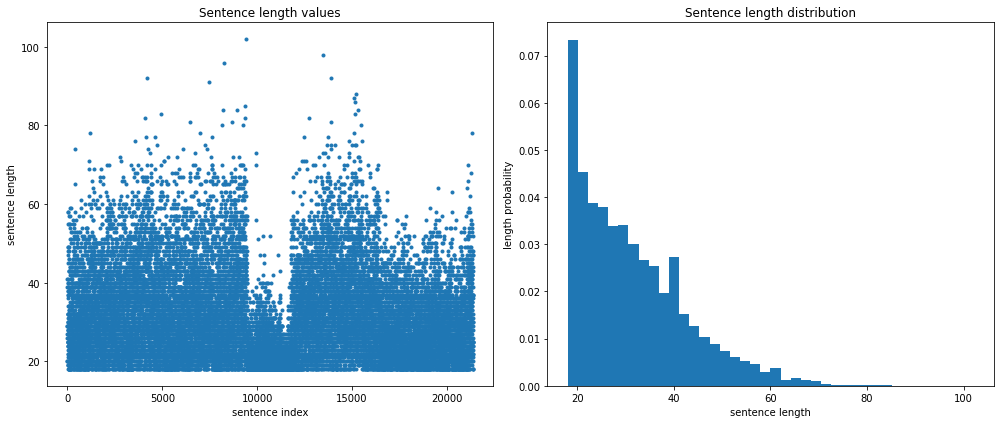

In [6]:
# Dataset visualization
lengths = [ len(sentence)  for sentence in dataset ]
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs.ravel()
axs[0].set_title('Sentence length values')
axs[0].set_xlabel('sentence index')
axs[0].set_ylabel('sentence length')
_ = axs[0].plot(lengths, '.')
axs[1].set_title('Sentence length distribution')
axs[1].set_xlabel('sentence length')
axs[1].set_ylabel('length probability')
_ = axs[1].hist(lengths, bins=40, density=True)

print('Mean sentence length:', np.mean(lengths))
print('Max sentence length:', np.max(lengths))
print('Min sentence length:', np.min(lengths))

plt.tight_layout()
plt.savefig(images_path+f'/bible_{min_len}.png')
plt.show()

In [7]:
print(len(set(dataset.words)))

10775


In [8]:
# Define transformation 
dataset.transform = transforms.Compose([
    WordToIndex(dataset.words),
    ToTensor()
])

In [9]:
dataset[0]

tensor([   68,  7865,  2661,   212,  9874, 10000,  4711,    68,  2429,  7911,
           68,  5199,   212,  4090,  7865,  6662,  8242,  7865, 10149,  1287],
       dtype=torch.int32)

## Split data

In [10]:
# Parameters

args = {
        # Dataset
        'min_len' : 18,
        # Network
        'emsize' : 240, # embedding dimension
        'nhid' : 2**6, # the dimension of the feedforward network model in nn.TransformerEncoder
        'nlayers' : 4, # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        'nhead' : 4, # the number of heads in the multiheadattention models
        'dropout' : 0.4, # the dropout value
        # Training
        'epochs' : 40,
        'batch_size' : 1200, # large batch_size to avoid overfitting
        'eval_batch_size' : 10,
        'clip' : 0.25, # gradient clipping
        'bptt' : 35, # sequence length
        'tied' : True,
        'log_interval' : 2 # report interval
        }

In [11]:
# Split initial dataset in train dataset and test dataset
train_dataset, test_dataset = split_train_test(dataset, 0.9)

# Create batches
train_data = batchify(train_dataset, args['batch_size']).to(device)
val_data = batchify(test_dataset, args['eval_batch_size']).to(device)

# Transformer model

In [12]:
# Number of words
ntokens = len(dataset.words)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize network
net = TransformerModel(ntokens, args['emsize'], args['nhead'], args['nhid'], args['nlayers'], args['dropout'])

# Optimizer
optimizer = torch.optim.Adam(net.parameters())

# Output path
out_dir = res_path +'{}_{}_{}_{}_{}_{}'.format( args['min_len'],
                                                args['emsize'],
                                                args['nhid'],
                                                args['nlayers'],
                                                args['nhead'],
                                                args['batch_size']
                                               )
# Move network to the selected device
net.to(device)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=240, out_features=240, bias=True)
        )
        (linear1): Linear(in_features=240, out_features=64, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=64, out_features=240, bias=True)
        (norm1): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=240, out_features=240, bias=True)
        )
        (linear1): Linear(in_features=240,

In [13]:
# Loop over epochs
best_val_loss = None
# Initialize encoder and decoder
w2i = WordToIndex(dataset.words)
# Set the flag for checkpoint usage
use_checkpoint = False
start = 1

# Load checkpoint
if use_checkpoint:
    # Load hyperparameters
    with open(out_dir / 'training_json', 'r') as f:
        training_args = json.load(f)
    start = training_args['epoch'] + 1
    # Load losses
    with open(out_dir / 'loss.json', 'r') as f:
          loss_dict = json.load(f)
    training_loss = loss_dict['training']
    validation_loss = loss_dict['validation']

    # Load model
    state_dict = torch.load(res_path + out_dir / 'net_params.pth', map_location = device)
    # Load weights
    net.load_state_dict(state_dict)
    net.to(device)
    # Load optimizer
    opt_dict = torch.load(out_dir / 'opt_params.pth', map_location = device)
    optimizer.load_state_dict(opt_dict)

## Training
epochs = args['epochs']
training_loss, validation_loss = [], []
for epoch in range(start, epochs+1):
    epoch_start_time = time.time()
    train_loss = train(net, optimizer, loss_fn, train_data, ntokens, args['clip'], epoch, log_interval=args['log_interval'])
    training_loss.append(float(train_loss))
    val_loss = evaluate(net, loss_fn, val_data, ntokens)
    validation_loss.append(float(val_loss))

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
            'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                       val_loss, math.exp(val_loss)))
    print('-' * 89)

    if (epoch) % 5 == 0:
            # Set seed
            state = 'The time is right for'
            # Generate sample text
            print('-' * 89)
            generate_text(5, state, dataset.words, net, w2i, ntokens, device)
            print('\n'+'-' * 89)

    ### Save all needed parameters (CHECKPOINT)
    # Create output dir
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Save network parameters
    torch.save(net.state_dict(), out_dir / 'net_params.pth')
    # Save optimizer parameters
    torch.save(optimizer.state_dict(),out_dir / 'opt_params.pth')

    training_args = args.copy()
    training_args['ntokens'] = ntokens
    training_args['epoch'] = epoch

    with open(out_dir / 'training_json', 'w') as f:
        json.dump(training_args, f, indent=4)

    # Save losses sequence dictionary
    loss_dict = {'training': training_loss,
                'validation': validation_loss
                }

    with open(out_dir / 'loss.json', 'w') as f:
        json.dump(loss_dict, f, indent=4)

| epoch   1 |     2/    9 batches | ms/batch 1433.71 | loss 13.69
| epoch   1 |     4/    9 batches | ms/batch 895.73 | loss  7.94
| epoch   1 |     6/    9 batches | ms/batch 893.06 | loss  7.37
| epoch   1 |     8/    9 batches | ms/batch 896.60 | loss  6.93
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 13.97s | valid loss  6.29 | valid ppl   537.39
-----------------------------------------------------------------------------------------
| epoch   2 |     2/    9 batches | ms/batch 1348.55 | loss  9.52
| epoch   2 |     4/    9 batches | ms/batch 901.12 | loss  6.09
| epoch   2 |     6/    9 batches | ms/batch 906.60 | loss  5.94
| epoch   2 |     8/    9 batches | ms/batch 906.12 | loss  5.87
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 14.08s | valid loss  5.78 | valid ppl   322.93
------------------------------------------------------------

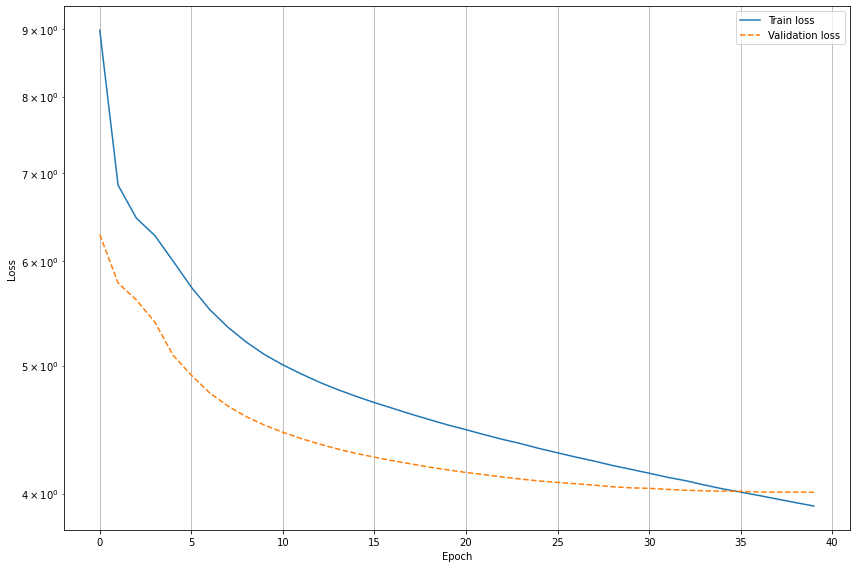

In [14]:
label = '{}_{}_{}_{}_{}_{}'.format( args['min_len'],
                                    args['emsize'],
                                    args['nhid'],
                                    args['nlayers'],
                                    args['nhead'],
                                    args['batch_size']
                                    )

# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))

plt.semilogy(training_loss, label='Train loss')
plt.semilogy(validation_loss, label='Validation loss', linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(images_path+f"/model_losses_"  + label + "_bible" + ".png")
plt.show()

# Text generation

In [15]:
w2i = WordToIndex(dataset.words)
n = 500

In [16]:
# Retrieve training arguments
training_args = json.load(open('{}/training_json'.format(out_dir)))

# Build the model
net = TransformerModel(ntokens,
                      training_args['emsize'],
                      training_args['nhead'],
                      training_args['nhid'],
                      training_args['nlayers'],
                      training_args['dropout']).to(device)

# Update the weights
net.load_state_dict(torch.load('{}/net_params.pth'.format(out_dir), map_location='cpu'))
net.to(device)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=240, out_features=240, bias=True)
        )
        (linear1): Linear(in_features=240, out_features=64, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=64, out_features=240, bias=True)
        (norm1): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=240, out_features=240, bias=True)
        )
        (linear1): Linear(in_features=240,

In [18]:
# Set the model in evaluation state
net.eval()

# Set initial word
state = 'I want you to know that'

print('\n')

# Text generation function
generate_text(n, state, dataset.words, net, w2i, ntokens, device)

# Set initial word
state = 'Sin is'

print('\n')

# Text generation function
generate_text(n, state, dataset.words, net, w2i, ntokens, device)

# Set initial word
state = 'The immigration issue can be solved'

# Text generation function
generate_text(n, state, dataset.words, net, w2i, ntokens, device)



TEXT:
i want you to know that thing; and i am here.
And the priests of the levites, bigthan and anathoth with burdens, and caves, and together in all the heathen, and that chew the lump of the cud, and the coulters which did do it is christ; and for this bond of his own conceit.
Sith thou hypocrite, and musical instruments of the mire of much exceeding throat is full of the just man knoweth any work of it whispered, suffering the mizar.
And it be unclean until the elect's sake there is a dream also, and milk of a lion ran through the first day of a strong drink of the king's chamberlains, and to me under foot of the third year; and the synagogue.
And in a vile person, whereby the pharisees hath done to heart to the shaking of the menservants, and the beasts, and the grecians against the waters which is defiled herself will so do: and the serpent's youngest son of the cunning men laid equity shall be well the good courage: why did thyself.
But they may be clean beast ye have not conti